In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm

#Polynomial Chaos E. terms ----------------------------------------------

def hermite(x,n):
    if n==0:
        return 1
    elif n==1:
        return x
    elif n==2:
        return (x**2-1)/(np.sqrt(2))
    elif n==3:
        return (x**3-3*x)/(np.sqrt(6))
    elif n==4:
        return (x**4-6*x**2+3)/(np.sqrt(24))
    elif n==5:
        return (x**5-10*x**3+15*x)/(np.sqrt(120))

def legendre(x,n):
    if n==0:
        return 1
    elif n==1:
        return x*(np.sqrt(3))
    elif n==2:
        return (3*x**2-1)*(np.sqrt(5))/2
    elif n==3:
        return (5*x**3-3*x)*(np.sqrt(7))/2
    elif n==4:
        return (35*x**4-30*x**2+3)*(np.sqrt(9))/8
    elif n==5:
        return (63*x**5-70*x**3+15*x)*(np.sqrt(11))/8  
    
def scalelegendre(x,new_min,new_max): 
    return ((new_min+new_max)+((new_max-new_min)*x))/2

def scalehermite(x,mean,sigma):
    return mean+sigma*x

def PCE(x,Y_):
    M_= 0
        
    for j in range (0,len(Y_)):
           
        M_ = M_ + Y_[j] * M1(x,j)  #M1 legendre / M2 hermite

    return M_

#Kriging --------------------------------------------------------------

def distance(x,xk):
    return x.reshape(-1,1)-xk.reshape(1,-1)

def euclid(r,l,scale):   #using kernell squared Euclidean distance
    return scale*np.exp(-((r**2)/(2*l**2)))

def GaussianPred(x,xn,yn,F,B):
    COV_nn=euclid(distance(xn,xn),l,sig)
    COV_xn=euclid(distance(x,xn),l,sig)
    COV_mult=np.matmul(COV_xn,np.linalg.inv(COV_nn))
    #-------------------------------------
    COV_xx=euclid(distance(x,x),l,sig)
    mean=np.matmul(COV_mult,(yn-np.matmul(F,B)))
    #-------------------------------------
    variance=np.subtract(COV_xx,np.matmul(COV_mult,COV_xn.transpose()))
    variaDiag=np.diagonal(variance)
    return [mean,variaDiag];

def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [1D array]
    dist=abs(distance(x,xn))
    voro=np.argmin(np.squeeze(dist))
    return voro

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF1(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

In [2]:
#function to evaluate -------------------------------------------

def function(x):
    return 2-100*(np.sin(x*7)+np.cos(14*x))*(x**2)*np.exp(-4*x)

In [414]:
def function2(x):
    return np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

In [2]:
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg


In [497]:
#definition of input parameters----------------------------------------------
np.random.seed(10)         #fixing seed random number generator

dim=2       # dimensionality
n=1000       # observations

#-----------------------------------------------------random Variable 1
x1 = np.random.normal(0,1,n)         #normal
x1mean = 1.5                            
x1sigma = 1.0                        
x1r=scalehermite(x1,x1mean,x1sigma)  #values to evaluate real function
M1=hermite                           #type of polynomial for PCE
#-----------------------------------------------------random Variable 2
x2 = np.random.normal(0,1,n)         #normal
x2mean= 2.5                          
x2sigma= 1.0                         
x2r=scalehermite(x2,x2mean,x2sigma)  #values to evaluate real function
M2=hermite                           #type of polynomial for PCE
#=====================================================
# xn=np.stack((x1,x2),axis=1)             #Single array for input variables/observations in hermite/legendre ranges
# xr=np.stack((x1r,x2r),axis=1)           #Single array for input variables/observations

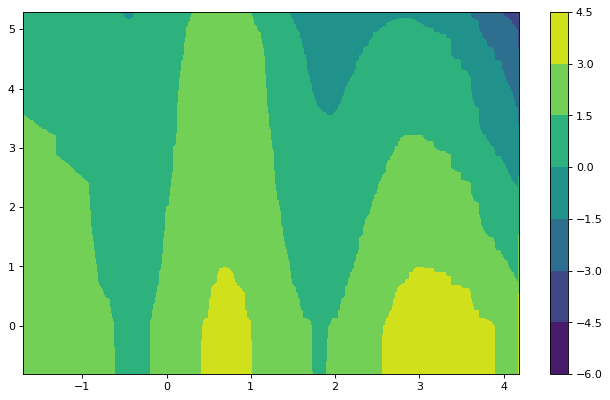

In [509]:
np.random.seed(10) 
ntest=1000       # observations

x1t = np.random.normal(x1mean,x1sigma,ntest) 
x2t = np.random.normal(x2mean,x2sigma,ntest) 
X1t,X2t = np.meshgrid(np.sort(x1t), np.sort(x2t))
Xt=np.stack((X1t,X2t),axis=2).reshape(-1,2)
yt=gfun_53(X)

fig =plt.subplots(figsize=(10, 6), dpi=80)

gsys=yt[0].reshape(ntest,-1)

cs = plt.contourf(np.sort(x1t), np.sort(x2t), gsys)
cbar=plt.colorbar(cs)
# cs.cmap.set_over('red')
# cs.cmap.set_under('blue')
cs.changed()

In [128]:
npop=1000
# np.random.seed(0)         #fixing seed for random number 

x1min = 0.25                           #lower bound    
x1max = 1.2                            #upper bound 
xmc = np.random.uniform(x1min,x1max,npop)

In [129]:
n=10
# to split the initial population and built kriging
# np.random.shuffle(dataset)
xdoe, xpop = xmc[:n], xmc[n:]

y=function(xdoe)          #Observations

In [130]:
xdoe

array([0.77137283, 0.9294299 , 0.82262521, 0.76763902, 0.65247206,
       0.86359941, 0.66570785, 1.09718435, 1.16547962, 0.61426944])

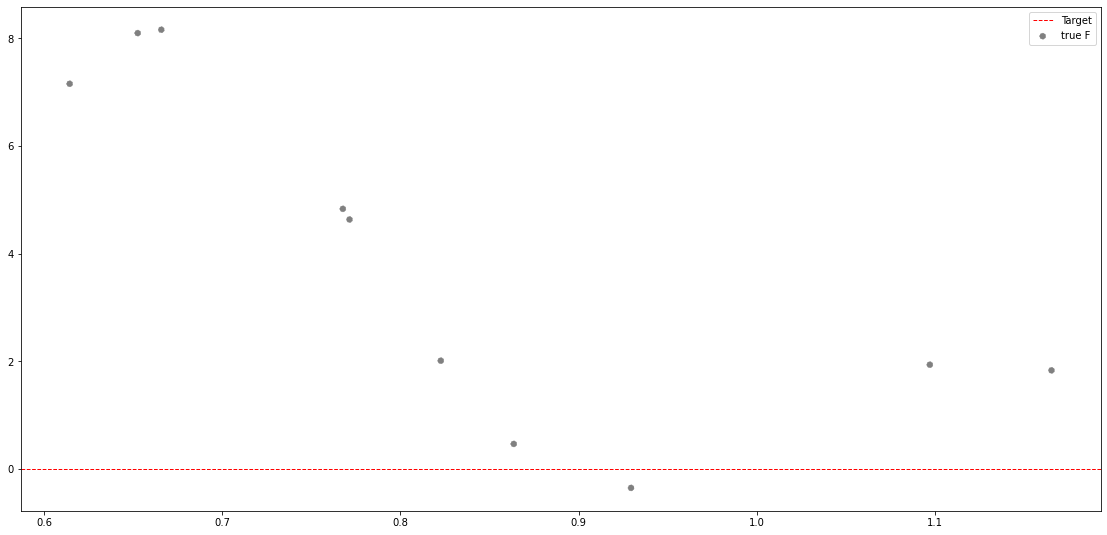

In [131]:
fig = plt.figure(figsize=(15,7))
ax=fig.add_axes([0,0,1,1])
ax.scatter(xdoe,y,label=r"true F",linestyle='dashed',linewidth=0.5,color='grey')
# ax.scatter(X1r,M,label=r"Predictions",color='g',s=10)
ax.axhline(y=0.0,label="Target", color='red', linestyle='dashed',linewidth=1)
# plt.scatter(x1r, y, label="Observations",marker="x",color='r', s=200)
plt.legend(prop={'size': 10})
# plt.title(label="PCE",fontsize=30)

In [132]:
#-----------------------------------------------------random Variable
M1 = legendre

# x1 = scalelegendre(xdoe,-1,1)
x1r=xdoe

x1=(2)*((x1r-x1min)/(x1max-x1min))+(-1)      #point in (-1,1) range

In [133]:
xdoe

array([0.77137283, 0.9294299 , 0.82262521, 0.76763902, 0.65247206,
       0.86359941, 0.66570785, 1.09718435, 1.16547962, 0.61426944])

In [134]:
x1

array([ 0.09762701,  0.43037873,  0.20552675,  0.08976637, -0.1526904 ,
        0.29178823, -0.12482558,  0.783546  ,  0.92732552, -0.23311696])

In [3]:
# n=3       # observations



# x1 = np.linspace(-1,1,n)
# x1 = np.random.uniform(-1,1,n)    #uniform
x1min = 0.25                           #lower bound    
x1max = 1.2                         #upper bound
x1r = scalelegendre(x1,x1min,x1max)
#-----------------------------------------------------random Variable
# M1=hermite
# x1=np.random.normal(0,1,n)         #normal
# x1mean= 0.6                          #mean 
# x1sigma= 0.1                         #standard deviation
# x1r=scalehermite(x1,x1mean,x1sigma)
#=====================================================
#=====================================================
# y=function(x1r)          #Observations

-----------------------------            FROM HERE AFTER ADDING A NEW POINT             -----------------------

In [151]:
#truncation term
p = 4   #degree of expansion

#Sampling matrix
A = np.zeros((n, p+1))
for i in range (0,n):
    for j in range (0,p+1):
        A[i,j] = np.array([M1(x1[i],j)])

#Learning coefficients by Least-Square Minimization
Atrans=A.transpose()
Inv=np.linalg.inv(np.matmul(Atrans, A))
Inv_Trans=np.matmul(Inv,Atrans)
Y=np.matmul(Inv_Trans,y)     #coefficients for PC =f(M) observations        

3784670.735510952


(-3.0, 10.0)

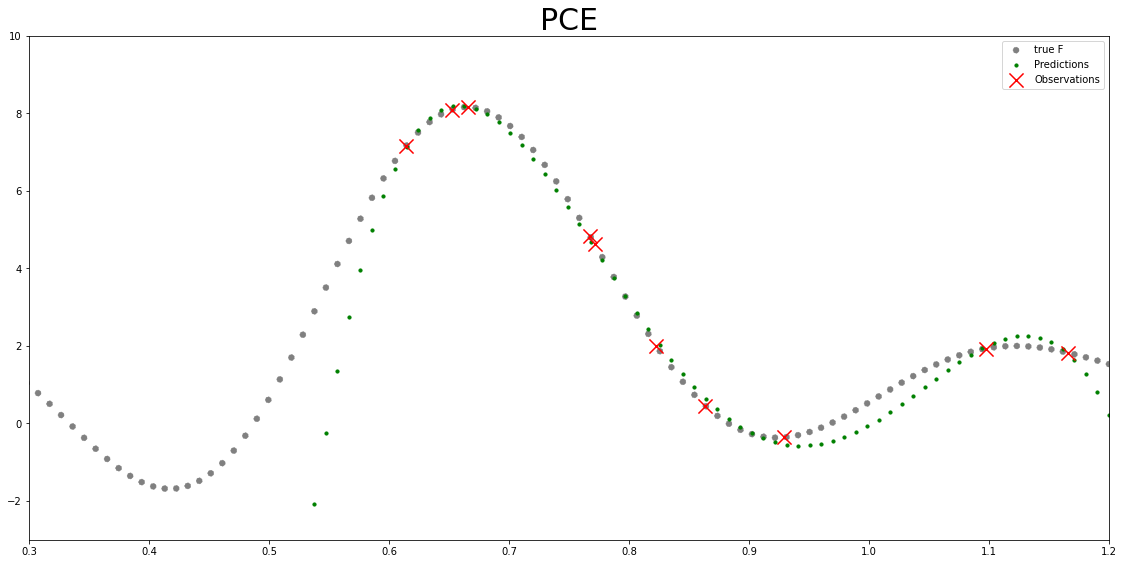

In [171]:
ntest=100

X1 = np.linspace(-1,1,ntest)
# X1=np.random.uniform(-1,1,ntest)
X1r=scalelegendre(X1,x1min,x1max)

# X1=np.random.normal(0,1,ntest)
# X1r=scalehermite(X1,x1mean,x1sigma)

# MSE=np.sum((Mtest-M)**2)
# print(MSE)
# print(Y_[0],np.mean(Mtest))
# %matplotlib notebook 

Mtest=function(X1r)
M=PCE(X1,Y)
# M=PCE(X1,p,M1,Y)

#Error estimator - Leave-one-out cross validation (ELOO)
hiMat=np.matmul(A,Inv_Trans)

Sum=0
for i in range(0,n):
    Sumi=((y[i]-M[i])/(1-hiMat[i,i]))**2
    Sum=Sum+Sumi
ELOO=Sum/n
print(ELOO)

fig = plt.figure(figsize=(15,7))
ax=fig.add_axes([0,0,1,1])
ax.scatter(X1r,Mtest,label=r"true F",linestyle='dashed',linewidth=0.5,color='grey')
ax.scatter(X1r,M,label=r"Predictions",color='g',s=10)
plt.scatter(x1r, y, label="Observations",marker="x",color='r', s=200)
plt.legend(prop={'size': 10})
plt.title(label="PCE",fontsize=30)
plt.xlim([0.3, 1.2])
plt.ylim([-3, 10.0])

# Kriging Model

In [209]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e5))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
gaussian_process.fit(x1r.reshape(-1,1), y.reshape(-1,1))
gaussian_process.kernel_

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


5.69**2 * RBF(length_scale=0.183)

In [141]:
# [KrigMean,variaDiag]=GaussianPred(t2,xn,M,A,Y)
# meanpred=PC+KrigMean.reshape(-1,1)

In [230]:
# kernel hyperparameters------------------------
l=0.183     #0.184
sig=5.69**2  #0.1**2
# KRIGING Predictions---------------------------
# meanpred=np.zeros([n])
# KRIGING mean-----------------------------------
COV_nn=euclid(distance(x1r,x1r),l,sig)           # R  correlation between observed points
COV_xn=euclid(distance(X1r,x1r),l,sig)           # r'(x)  correlation, new points with observations
COV_mult=np.matmul(COV_xn,np.linalg.inv(COV_nn))   #  r'(x) * R^-1
FB=np.matmul(A,Y)
KrigMean=np.matmul(COV_mult,(y-FB)) #.reshape(-1,1)
meanpred=M+KrigMean
# KRIGING variance-------------------------------
COV_xx=euclid(distance(X1r,X1r),l,sig)
variance=np.subtract(COV_xx,np.matmul(COV_mult,COV_xn.transpose())) #
variaDiag=np.diagonal(variance) #.reshape(-1,1)

In [143]:
# z=0     #target value
# # eff0=EFF(meanpred,variaDiag,z)
# eff1 = np.zeros((ntest))
# eff1=EFF1(meanpred,variaDiag,z)
# # ynew=np.argmax(eff1)
# # xnew=meanpred(ynew)

In [231]:
def U_function(u,v):
    return u/v

U_f=U_function(meanpred,variaDiag)

Text(0.5, 1.0, 'U_PCK')

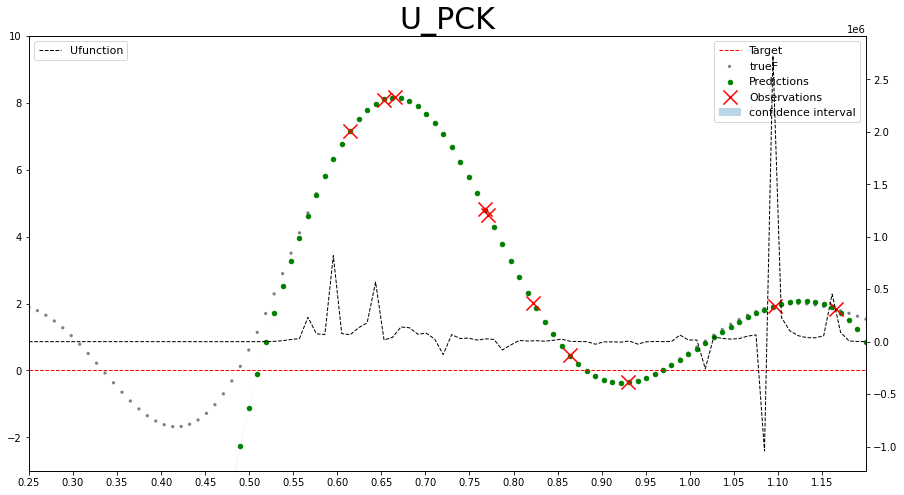

In [232]:
ymin=(meanpred - 1.5*variaDiag) #.reshape(-1,1)
ymax=(meanpred + 1.5*variaDiag) #.reshape(-1,1)

# sorting in case of random samples for ploting
# ind=np.argsort(np.squeeze(X1r))
# a,b,c=np.asarray(X1r)[ind], np.asarray(ymin)[ind], np.asarray(ymax)[ind]

#%matplotlib notebook 
fig, ax1 = plt.subplots(figsize=(15,8))

ax2=ax1.twinx()

ax1.scatter(X1r,Mtest,label=r"trueF",linestyle='dashed',linewidth=0.1,s=10,color='grey')
ax1.scatter(X1r,meanpred,label=r"Predictions",color='g',marker="o",s=20)
ax1.scatter(x1r, y, label="Observations",marker="x",color='r',s=200)
ax1.fill_between(
    X1r.ravel(),
    ymin.ravel(),
    ymax.ravel(),
#     a.ravel(),
#     b.ravel(),
#     c.ravel(),
    alpha=0.3,
    label=r"confidence interval",
)

# ax2.plot(X1r,eff0,label="EFF",linestyle='dashed',linewidth=1,color='k')
ax2.plot(X1r,U_f,label="Ufunction",linestyle='dashed',linewidth=1,color='k')

ax1.axhline(y=0.0,label="Target", color='red', linestyle='dashed',linewidth=1)
ax1.legend(prop={'size': 11})
ax2.legend(prop={'size': 11})

plt.xlim([0.25, 1.2])
ax1.set_ylim(-3, 10.0)
ax1.set_ylim(-3, 10.0)

plt.xticks(np.arange(min(X1r), max(X1r), 0.05))
plt.title(label="U_PCK",fontsize=30)

max point

In [289]:
xrnew=X1r[np.argmax(eff1)]
print(xrnew)

0.9673469387755101


Add a new observation 

In [290]:
#xrnew=0.99   #point in real x axis

#updating the related parameters

xnew=(2)*((xrnew-x1min)/(x1max-x1min))+(-1)      #point in (-1,1) range

x1 = np.append(x1,xnew)
x1r = np.append(x1r,xrnew)

y=function(x1r)
n=len(x1r)

U Function

# LeaveOneOut_CrossValidation

In [7]:
# xhe=xleg
PC_loo=np.zeros(n)
KrigMeanloo=np.zeros(n)
KrigVarloo=np.zeros(n)
PC_looALL=np.zeros((n,ntest))
KrigMeanlooALL=np.zeros((n,ntest))
KrigVarlooALL=np.zeros((n,ntest))

for i in range (0,n):
    M_loo=np.delete(M,[i])          #y_n-i     leaving element i out the observations (M)
    xhe_loo=np.delete(xhe,[i])      #xhe_n-i   leaving element i out the hermite inputs (xi)
    xn_loo=np.delete(xn,[i])        #x_n-i     leaving element i out the inputs (xi)

    #Sampling matrix (F matrix) evaluation of the samples in a sparse p polynomials matrix from PCE
    F_loo = np.zeros((n-1, degree+1))
    B_loo = np.zeros((degree+1,1))
    n_loo = len (F_loo)
    
    for j in range (0,n_loo):
        for k in range (0,degree+1):
            F_loo[j,k] = np.array([poly(xhe_loo[j],k)])
            
    #Learning coefficients by Least-Square Minimization
    Ftrans=F_loo.transpose()
    Inv=np.linalg.inv(np.matmul(Ftrans, F_loo))
    Inv_Trans=np.matmul(Inv,Ftrans)
    B_loo=np.matmul(Inv_Trans,M_loo)                #B coefficients for PC =f(M_loo) observations
    
    # PCE mean prediction --------------leaving i-term out
    PC_loo[i]=PCE([xhe[i]],degree,poly,B_loo)   #following coefficients B
    PC_looALL[i]=np.squeeze(PCE(tleg2,degree,poly,B_loo))
    
    # KRIGING mean--------------leaving i-term out
    [KrigMeanloo[i],KrigVarloo[i]]=GaussianPred(xn[i],xn_loo,M_loo,F_loo,B_loo)    #following coefficients B
    [KrigMeanlooALL[i],KrigVarlooALL[i]]=GaussianPred(t2,xn_loo,M_loo,F_loo,B_loo)
    
mean_loo=PC_loo+KrigMeanloo
e_loo=(M-mean_loo)**2
sumat=np.divide(e_loo,KrigVarloo)
mean_looALL=PC_looALL+KrigMeanlooALL

LOOCV=np.zeros(predict)
cell=np.zeros(predict)
for k in range (0,predict):  
    voro = VoronoiCell(t2[k],xn)
    LOOCV[k]= variaDiag[k]*(1+sumat[voro])
#     cell[k] = voro

Text(0, 0.5, 'Quantity of Interest (QoI)')

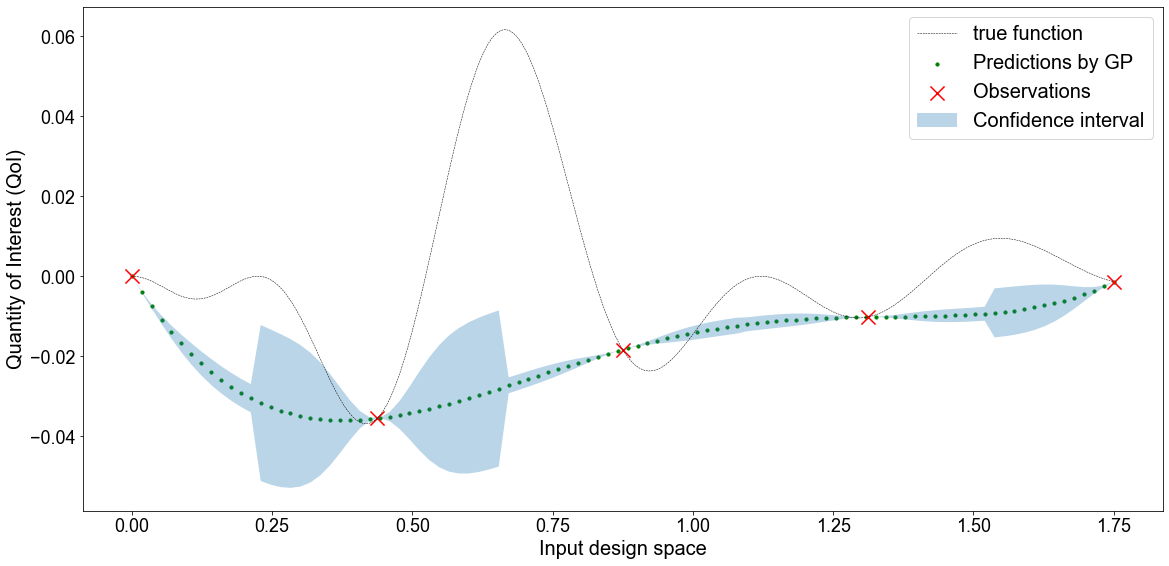

In [23]:
yminloo=(meanpred - 1.0*LOOCV.reshape(-1,1))
ymaxloo=(meanpred + 1.0*LOOCV.reshape(-1,1))
# hfont = {'fontname':'Arial'}
plt.rcParams.update({'font.family':'Arial'})

size=20

nloo=1   #to check the shape of the n-loo predictors
#sorting in case of random samples for ploting variance (fill between)
# indp=np.argsort(np.squeeze(t2))
ap,bp,cp=np.asarray(t2)[ind], np.asarray(yminloo)[ind], np.asarray(ymaxloo)[ind]

Varimax= np.argmax(cp-bp)
xnew=ap[Varimax]
ynew=function(xnew)

fig = plt.figure(figsize=(15,7))
ax=fig.add_axes([0,0,1,1])
ax.plot(t,y,label=r"true function",linestyle='dashed',linewidth=0.5,color='k')
ax.scatter(t2,meanpred,label=r"Predictions by GP",color='g',s=10)
# ax.scatter(xn,mean_loo,label=r"Prediction LOOCV",color='y',s=200,marker="+")
plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)

# ax.scatter(t2,mean_looALL[nloo],label=r"Prediction LOO-ALL",color='y',s=20,marker="+")
# ax.scatter(t2,KrigMeanlooALL[nloo],label=r"Prediction KrigALL",color='#17becf',s=20,marker="*")
# ax.scatter(t2,PC_looALL[nloo],label=r"Prediction PCEALL",color='#1f77b4',s=20,marker="x")

# plt.scatter(xnew,ynew,label="NewPoint",marker="o",color='r',s=200)

plt.fill_between(
    ap.ravel(),
    bp.ravel(),
    cp.ravel(),
    alpha=0.3,
    label=r"Confidence interval",
)
plt.legend(prop={'size': size})
plt.tick_params(axis='x', labelsize=size*0.9)
plt.tick_params(axis='y', labelsize=size*0.9)
plt.xlabel('Input design space', fontsize=size)
plt.ylabel('Quantity of Interest (QoI)', fontsize=size)
# plt.xlim([0, 2.5])
# plt.ylim([-3, 5])
# plt.title(label="PCE _ Kriging _LOO CV",fontsize=30)

In [ ]:
n=500   #Max batch size for training

#Spliting of points for training and testing
np.random.shuffle(dataset)
training, test = dataset[:n,:], dataset[n:,:]

#Angle and Velocity inputs

Output = 5       #Col5 = Penetration | Col6 = Impact Force

Xtrain = training[:, [0, 1, 2, 3]]   #Col0 = Angle | Col1 = Velocity | Col2 = DLeg | Col0 = Angle
Ytrain = training[:, Output]   

Xtest = test[:, [0, 1, 2, 3]]
Ytest = test[:, Output]

In [109]:
x5 = np.linspace(-5, 5, 101)
y5 = np.linspace(-5, 5, 101)

In [111]:
xx, yy = np.meshgrid(x5, y5)
zz = np.sqrt(xx**2 + yy**2)

((101, 101), (101, 101), (101, 101))

In [117]:
xs, ys = np.meshgrid(x5, y5, sparse=True)
zs = np.sqrt(xs**2 + ys**2)
xs.shape, ys.shape, zs.shape

((1, 101), (101, 1), (101, 101))

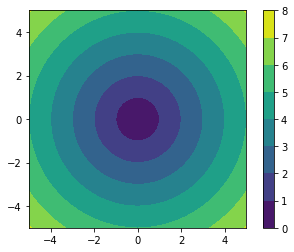

In [119]:
h = plt.contourf(x5, y5, zs)
plt.axis('scaled')
plt.colorbar()
plt.show()